In [16]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [17]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# ml2023spring_hw1_path = kagglehub.competition_download('ml2023spring-hw1')

# print('Data source import complete.')


# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

In [18]:
!nvidia-smi

Sun Nov 30 13:30:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Download data
If the Google Drive links below do not work, you can use the dropbox link below or download data from [Kaggle](https://www.kaggle.com/t/a339b77fa5214978bfb8dde62d3151fe), and upload data manually to the workspace.

In [19]:
# google drive link
# !pip install gdown
# !gdown --id '1BjXalPZxq9mybPKNjF3h5L3NcF7XKTS-' --output covid_train.csv
# !gdown --id '1B55t74Jg2E5FCsKCsUEkPKIuqaY7UIi1' --output covid_test.csv

# dropbox link
!wget -O covid_train.csv https://www.dropbox.com/s/lmy1riadzoy0ahw/covid.train.csv?dl=0
!wget -O covid_test.csv https://www.dropbox.com/s/zalbw42lu4nmhr2/covid.test.csv?dl=0

--2025-11-30 13:30:58--  https://www.dropbox.com/s/lmy1riadzoy0ahw/covid.train.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ewl0ff7lviu0s7f53jp9o/covid.train.csv?rlkey=pocojbo26thh2ncv0xkxfafiv&dl=0 [following]
--2025-11-30 13:30:59--  https://www.dropbox.com/scl/fi/ewl0ff7lviu0s7f53jp9o/covid.train.csv?rlkey=pocojbo26thh2ncv0xkxfafiv&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce122ad5acd46a40028e21aa27f.dl.dropboxusercontent.com/cd/0/inline/C2IZ8y0jqI-espFWkcKJzd_NERrqX1piwXSVPkR_t3sCWqBN6-1V_S9QL-4uplCh-XsPLTEMxzUBNo9_zEycapYNBJhP5LPfBMieFnCPI_JW-pjZfPVieSzs2xspZGm-ViggFInzsTBX4GNLQbB6mGbO/file# [following]
--2025-11-30 13:30:59--  https://uce122ad5acd46a40028e21aa27f.dl.dropboxus

# Import packages

In [20]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm # 一个进度条库，可以在长循环中添加一个进度提示信息

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter # 一个用于可视化训练过程的工具

In [21]:
for i in tqdm(range(100), desc="Processing"):  # tqdm 用于显示进度条
    i

Processing: 100%|██████████| 100/100 [00:00<00:00, 403298.46it/s]


# Some Utility Functions

You do not need to modify this part.

In [22]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) 
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set))
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# Dataset

In [23]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = None
        else:
            self.y = torch.tensor(y, dtype=torch.float32)
        self.x = torch.tensor(x, dtype=torch.float32)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [24]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions.
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),

            nn.Linear(4, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [25]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data
    
    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # feat_idx = list(range(35, raw_x_train.shape[1])) # TODO: Select suitable feature columns.
        feat_idx = []
        symptom_idx = [
            35, 36, 37, 47, 48,  # cli, ili, wnohh_cmnty_cli, hh_cmnty_cli, nohh_cmnty_cli
            53, 54, 55, 65, 66,  # cli.1, ili.1, wnohh_cmnty_cli.1, hh_cmnty_cli.1, nohh_cmnty_cli.1
            71, 72, 73, 83, 84   # cli.2, ili.2, wnohh_cmnty_cli.2, hh_cmnty_cli.2, nohh_cmnty_cli.2
        ]
        # 2. 公众行为类指标 下标
        behavior_idx = [
            40, 41, 42, 43, 44, 45, 49, 50,  # wcovid_vaccinated_friends ~ public_transit
            58, 59, 60, 61, 62, 63, 67, 68,  # 带.1后缀的行为类指标
            76, 77, 78, 79, 80, 81, 85, 86   # 带.2后缀的行为类指标
        ]
        # 3. 健康结果类指标 下标
        health_idx = [
            52,  # tested_positive
            70,  # tested_positive.1
            88   # tested_positive.2
        ]
        keep_idx = list(set(symptom_idx + behavior_idx + health_idx))
        keep_idx.sort()
        feat_idx.extend(keep_idx)

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [26]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm.
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7)
    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device.
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())

            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 1112,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 50,     # Number of epochs.
    'batch_size': 256,
    'learning_rate': 1e-5,
    'early_stop': 600,    # If model has not improved for this many consecutive epochs, stop training.
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [28]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 3009 x 89 (35 states + 18 features x 3 days)
# test_data size: 997 x 88 (without last day's positive rate)
# train_data, test_data = pd.read_csv('./covid_train.csv').values, pd.read_csv('./covid_test.csv').values
train_data, test_data = pd.read_csv('./covid_train.csv'), pd.read_csv('./covid_test.csv')


# for idx, col_name in enumerate(train_data.columns):
#     # 输出格式：下标 -> 列名
#     print(f"下标 {idx} -> 列名: {col_name}")
train_data = train_data.values
test_data = test_data.values

train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (2408, 89)
valid_data size: (601, 89)
test_data size: (997, 88)
number of features: 88


# Start training!

In [29]:
model = My_Model(input_dim=x_train.shape[1]).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/50]: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s, loss=398]


Epoch [1/50]: Train loss: 388.7254, Valid loss: 407.7289
Saving model with loss 407.729...


Epoch [2/50]: 100%|██████████| 10/10 [00:00<00:00, 164.41it/s, loss=486]


Epoch [2/50]: Train loss: 391.7428, Valid loss: 394.4299
Saving model with loss 394.430...


Epoch [3/50]: 100%|██████████| 10/10 [00:00<00:00, 162.49it/s, loss=347]


Epoch [3/50]: Train loss: 381.9495, Valid loss: 387.7189
Saving model with loss 387.719...


Epoch [4/50]: 100%|██████████| 10/10 [00:00<00:00, 125.74it/s, loss=392]


Epoch [4/50]: Train loss: 383.3809, Valid loss: 379.5838
Saving model with loss 379.584...


Epoch [5/50]: 100%|██████████| 10/10 [00:00<00:00, 130.26it/s, loss=496]


Epoch [5/50]: Train loss: 388.2239, Valid loss: 381.4374


Epoch [6/50]: 100%|██████████| 10/10 [00:00<00:00, 179.39it/s, loss=398]


Epoch [6/50]: Train loss: 380.7378, Valid loss: 381.7795


Epoch [7/50]: 100%|██████████| 10/10 [00:00<00:00, 166.11it/s, loss=388]


Epoch [7/50]: Train loss: 378.0512, Valid loss: 381.5597


Epoch [8/50]: 100%|██████████| 10/10 [00:00<00:00, 176.40it/s, loss=409]


Epoch [8/50]: Train loss: 377.7788, Valid loss: 390.6171


Epoch [9/50]: 100%|██████████| 10/10 [00:00<00:00, 169.48it/s, loss=366]


Epoch [9/50]: Train loss: 373.8386, Valid loss: 368.0688
Saving model with loss 368.069...


Epoch [10/50]: 100%|██████████| 10/10 [00:00<00:00, 158.65it/s, loss=367]


Epoch [10/50]: Train loss: 372.6415, Valid loss: 366.9248
Saving model with loss 366.925...


Epoch [11/50]: 100%|██████████| 10/10 [00:00<00:00, 161.46it/s, loss=421]


Epoch [11/50]: Train loss: 374.5606, Valid loss: 374.5779


Epoch [12/50]: 100%|██████████| 10/10 [00:00<00:00, 112.54it/s, loss=368]


Epoch [12/50]: Train loss: 370.2024, Valid loss: 368.4763


Epoch [13/50]: 100%|██████████| 10/10 [00:00<00:00, 106.03it/s, loss=389]


Epoch [13/50]: Train loss: 370.2300, Valid loss: 378.6500


Epoch [14/50]: 100%|██████████| 10/10 [00:00<00:00, 121.02it/s, loss=316]


Epoch [14/50]: Train loss: 364.6720, Valid loss: 372.0539


Epoch [15/50]: 100%|██████████| 10/10 [00:00<00:00, 127.89it/s, loss=446]


Epoch [15/50]: Train loss: 371.1992, Valid loss: 369.2497


Epoch [16/50]: 100%|██████████| 10/10 [00:00<00:00, 97.75it/s, loss=262]


Epoch [16/50]: Train loss: 358.9594, Valid loss: 373.2180


Epoch [17/50]: 100%|██████████| 10/10 [00:00<00:00, 95.73it/s, loss=381]


Epoch [17/50]: Train loss: 364.8617, Valid loss: 376.5258


Epoch [18/50]: 100%|██████████| 10/10 [00:00<00:00, 106.99it/s, loss=402]


Epoch [18/50]: Train loss: 364.7799, Valid loss: 382.0752


Epoch [19/50]: 100%|██████████| 10/10 [00:00<00:00, 111.90it/s, loss=331]


Epoch [19/50]: Train loss: 359.3490, Valid loss: 364.7956
Saving model with loss 364.796...


Epoch [20/50]: 100%|██████████| 10/10 [00:00<00:00, 105.01it/s, loss=316]


Epoch [20/50]: Train loss: 357.2046, Valid loss: 356.6233
Saving model with loss 356.623...


Epoch [21/50]: 100%|██████████| 10/10 [00:00<00:00, 97.50it/s, loss=286]


Epoch [21/50]: Train loss: 354.4952, Valid loss: 367.7681


Epoch [22/50]: 100%|██████████| 10/10 [00:00<00:00, 96.88it/s, loss=338]


Epoch [22/50]: Train loss: 356.1030, Valid loss: 365.1777


Epoch [23/50]: 100%|██████████| 10/10 [00:00<00:00, 130.79it/s, loss=374]


Epoch [23/50]: Train loss: 356.8595, Valid loss: 381.6084


Epoch [24/50]: 100%|██████████| 10/10 [00:00<00:00, 139.16it/s, loss=343]


Epoch [24/50]: Train loss: 353.8002, Valid loss: 348.7660
Saving model with loss 348.766...


Epoch [25/50]: 100%|██████████| 10/10 [00:00<00:00, 154.54it/s, loss=367]


Epoch [25/50]: Train loss: 353.8691, Valid loss: 378.8045


Epoch [26/50]: 100%|██████████| 10/10 [00:00<00:00, 111.95it/s, loss=411]


Epoch [26/50]: Train loss: 355.1907, Valid loss: 341.4588
Saving model with loss 341.459...


Epoch [27/50]: 100%|██████████| 10/10 [00:00<00:00, 84.21it/s, loss=374]


Epoch [27/50]: Train loss: 351.7648, Valid loss: 367.7568


Epoch [28/50]: 100%|██████████| 10/10 [00:00<00:00, 87.33it/s, loss=331]


Epoch [28/50]: Train loss: 347.7147, Valid loss: 358.2968


Epoch [29/50]: 100%|██████████| 10/10 [00:00<00:00, 20.82it/s, loss=360]


Epoch [29/50]: Train loss: 348.1096, Valid loss: 386.6148


Epoch [30/50]: 100%|██████████| 10/10 [00:00<00:00, 144.42it/s, loss=313]


Epoch [30/50]: Train loss: 344.1219, Valid loss: 349.9963


Epoch [31/50]: 100%|██████████| 10/10 [00:00<00:00, 156.71it/s, loss=406]


Epoch [31/50]: Train loss: 348.1211, Valid loss: 362.5170


Epoch [32/50]: 100%|██████████| 10/10 [00:00<00:00, 162.23it/s, loss=398]


Epoch [32/50]: Train loss: 346.3387, Valid loss: 337.3144
Saving model with loss 337.314...


Epoch [33/50]: 100%|██████████| 10/10 [00:00<00:00, 171.63it/s, loss=348]


Epoch [33/50]: Train loss: 341.9633, Valid loss: 350.6231


Epoch [34/50]: 100%|██████████| 10/10 [00:00<00:00, 141.64it/s, loss=334]


Epoch [34/50]: Train loss: 339.6402, Valid loss: 340.6998


Epoch [35/50]: 100%|██████████| 10/10 [00:00<00:00, 138.18it/s, loss=285]


Epoch [35/50]: Train loss: 335.3740, Valid loss: 355.7307


Epoch [36/50]: 100%|██████████| 10/10 [00:00<00:00, 136.39it/s, loss=316]


Epoch [36/50]: Train loss: 335.8528, Valid loss: 338.5643


Epoch [37/50]: 100%|██████████| 10/10 [00:00<00:00, 135.36it/s, loss=361]


Epoch [37/50]: Train loss: 336.9000, Valid loss: 346.9809


Epoch [38/50]: 100%|██████████| 10/10 [00:00<00:00, 137.98it/s, loss=308]


Epoch [38/50]: Train loss: 332.4204, Valid loss: 328.3650
Saving model with loss 328.365...


Epoch [39/50]: 100%|██████████| 10/10 [00:00<00:00, 129.98it/s, loss=317]


Epoch [39/50]: Train loss: 331.5575, Valid loss: 326.8794
Saving model with loss 326.879...


Epoch [40/50]: 100%|██████████| 10/10 [00:00<00:00, 140.58it/s, loss=284]


Epoch [40/50]: Train loss: 327.9713, Valid loss: 346.8712


Epoch [41/50]: 100%|██████████| 10/10 [00:00<00:00, 139.59it/s, loss=289]


Epoch [41/50]: Train loss: 326.7669, Valid loss: 326.7479
Saving model with loss 326.748...


Epoch [42/50]: 100%|██████████| 10/10 [00:00<00:00, 143.78it/s, loss=282]


Epoch [42/50]: Train loss: 324.9108, Valid loss: 330.2046


Epoch [43/50]: 100%|██████████| 10/10 [00:00<00:00, 139.08it/s, loss=334]


Epoch [43/50]: Train loss: 326.5194, Valid loss: 315.9334
Saving model with loss 315.933...


Epoch [44/50]: 100%|██████████| 10/10 [00:00<00:00, 133.51it/s, loss=303]


Epoch [44/50]: Train loss: 322.9910, Valid loss: 344.9303


Epoch [45/50]: 100%|██████████| 10/10 [00:00<00:00, 141.00it/s, loss=385]


Epoch [45/50]: Train loss: 326.4637, Valid loss: 340.3328


Epoch [46/50]: 100%|██████████| 10/10 [00:00<00:00, 139.03it/s, loss=281]


Epoch [46/50]: Train loss: 318.4819, Valid loss: 339.4611


Epoch [47/50]: 100%|██████████| 10/10 [00:00<00:00, 159.21it/s, loss=274]


Epoch [47/50]: Train loss: 316.5748, Valid loss: 307.9521
Saving model with loss 307.952...


Epoch [48/50]: 100%|██████████| 10/10 [00:00<00:00, 173.37it/s, loss=332]


Epoch [48/50]: Train loss: 318.3224, Valid loss: 347.4393


Epoch [49/50]: 100%|██████████| 10/10 [00:00<00:00, 147.49it/s, loss=312]


Epoch [49/50]: Train loss: 315.6951, Valid loss: 329.2070


Epoch [50/50]: 100%|██████████| 10/10 [00:00<00:00, 173.28it/s, loss=280]


Epoch [50/50]: Train loss: 312.1244, Valid loss: 342.6248


# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [30]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')

100%|██████████| 4/4 [00:00<00:00, 485.31it/s]


# Download

Run this block to download the `pred.csv` by clicking.

In [31]:
from IPython.display import FileLink
FileLink(r'pred.csv')

/content/pred.csv

Valid MAE: 15.5904, RMSE: 17.6570


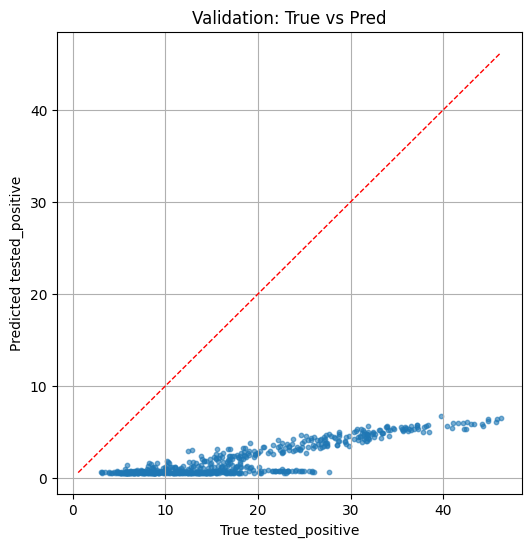

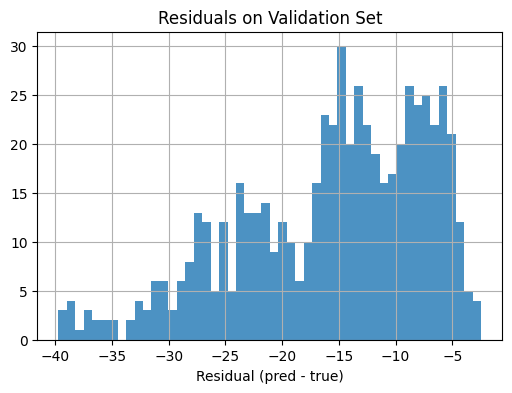

In [32]:
# 可视化：验证集 真值 vs 预测、残差直方图、MAE/RMSE
import matplotlib.pyplot as plt

def get_preds_and_targets(loader, model, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            # loader for valid/train yields (x, y)
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                x, y = batch
                x = x.to(device)
                p = model(x).detach().cpu().numpy()
                preds.append(p)
                targets.append(y.numpy())
            else:
                x = batch
                x = x.to(device)
                p = model(x).detach().cpu().numpy()
                preds.append(p)
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0) if targets else None
    return preds, targets

# 加载已保存的最佳模型权重（确保已训练并存在 config['save_path']）
model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path'], map_location=device))

# 在验证集上预测并计算指标
valid_preds, valid_targets = get_preds_and_targets(valid_loader, model, device)
mse = np.mean((valid_preds - valid_targets)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(valid_preds - valid_targets))
print(f'Valid MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# 散点图：真实值 vs 预测值
plt.figure(figsize=(6,6))
plt.scatter(valid_targets, valid_preds, alpha=0.6, s=10)
mn = min(valid_targets.min(), valid_preds.min())
mx = max(valid_targets.max(), valid_preds.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel('True tested_positive')
plt.ylabel('Predicted tested_positive')
plt.title('Validation: True vs Pred')
plt.grid(True)
plt.show()

# 残差直方图
res = valid_preds - valid_targets
plt.figure(figsize=(6,4))
plt.hist(res, bins=50, alpha=0.8)
plt.xlabel('Residual (pred - true)')
plt.title('Residuals on Validation Set')
plt.grid(True)
plt.show()

# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)